# Perceptual Loss SR(U-Net)GAN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation, Dense, Input, Dropout
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os, cv2
import tensorflow as tf
from keras import losses
from keras.optimizers import SGD,RMSprop,adam
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization
from IPython.display import clear_output
from sklearn.utils import shuffle
from keras.utils import np_utils
from keras.models import Sequential

Using TensorFlow backend.


# Data Loading and Manipulation 
The data is loaded from root directory and is trained on a small data set for testing purposes 

Working....


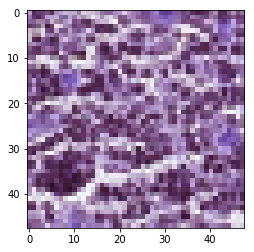

1000
2000
3000
4000
5000
6000
Done loading Training
Done Transforming
6419
(48, 48, 3)
Completed!
(3, 48, 48, 3)
(100, 48, 48, 3)


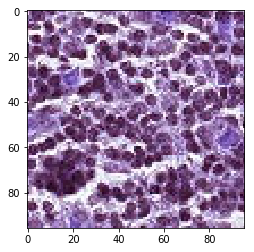

1000
2000
3000
4000
5000
6000
Done loading target
Done Transforming
6419
(96, 96, 3)
Completed!


In [2]:
PATH = os.getcwd()
# Define data path
data_path = "C:\\Users\\Administrator\\Untitled Folder\\test"
data_dir_list = os.listdir(data_path)

img_rows=48
img_cols=48
num_channel=3

img_data_list=[]
img_target_list=[]
count=0
print("Working....")
for img in data_dir_list:
    input_img = cv2.imread(data_path + "\\"+img)
    input_img=cv2.resize(input_img,(48,48))
    img_data_list.append(input_img)
    count+=1
    if(count%1000==0):
        print(count)
    if(count == 12):
        imgplt=plt.imshow(input_img)
        plt.show()
print("Done loading Training")
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
print("Done Transforming")
print (img_data.shape[0])
print (img_data[0].shape)
print("Completed!")
x_train = img_data[0:100,:,:,:]
x_test = img_data[101:104,:,:,:]
count=0
print (x_test.shape)
print(x_train.shape)





count=0
for img in data_dir_list:
    target_img = cv2.imread(data_path + "\\"+img)
    target_img=cv2.resize(target_img,(96,96))
    img_target_list.append(target_img)
    count+=1
    if(count%1000==0):
        print(count)
    if(count == 12):
        imgplt=plt.imshow(target_img)
        plt.show()
print("Done loading target")
target_data = np.array(img_target_list)
target_data = target_data.astype('float32')
target_data /= 255
print("Done Transforming")
print (target_data.shape[0])
print (target_data[0].shape)
print("Completed!")
target_data_train = target_data[0:100,:,:,:]
target_data_test = target_data[101:104,:,:,:]


# Define A Few Parameters 

In [3]:
# Network parameters
input_shape = (48, 48, 3)
batch_size = 8
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Building Encoder Network

In [4]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               padding='same', kernel_initializer='glorot_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12, 12, 64)        0         
__________

# Building Decoder Network

In [5]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [6]:
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        padding='same' ,kernel_initializer='glorot_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

x = Conv2DTranspose(filters=3,
                    kernel_size=kernel_size,
                    strides=2,
                    padding='same', kernel_initializer='glorot_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2DTranspose(filters=3,
                    kernel_size=kernel_size,
                    padding='same', kernel_initializer='glorot_normal')(x)
outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9216)              156672    
_________________________________________________________________
reshape_1 (Reshape)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 48, 48, 32)        18464     
__________

# Loading Perception Loss Network (vgg16 Neural Transfer)

In [7]:
import keras
from keras.applications import VGG16
vgg = VGG16(weights='imagenet',classes=1000,input_shape=(96,96,3), include_top=False)
vgg.compile(optimizer="adam",loss='categorical_crossentropy')
disc = Sequential()
for layer in vgg.layers:
    disc.add(layer)
for layer in disc.layers:
    layer.trainable = False
disc.add(Flatten())
disc.add(Dense(4608, activation='softmax'))
disc.add(Dense(2, activation='softmax'))
disc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 24, 24, 256)       295168    
__________

# Graph Function (Optional)

In [8]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        #plt.savefig('C:\\Users\\Administrator\\Untitled Folder\figure.png', dpi = 300)
        
plot_losses = PlotLosses()

# Inital Training Of Generator Network

In [9]:
gen = Model(inputs, decoder(encoder(inputs)), name='Generator')
gan = Model(inputs, disc(gen(inputs)), name='GAN')
sgd = SGD(lr=1e-4, clipnorm=1, clipvalue=0.5)
disc.compile(loss='mean_squared_logarithmic_error', optimizer=sgd,  metrics=['acc'])



gen = Model(inputs, decoder(encoder(inputs)), name='Generator')
gan = Model(inputs, disc(gen(inputs)), name='GAN')
import pydot
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png')
plot_model(decoder, to_file='decoder.png')
plot_model(disc, to_file='disc.png')
plot_model(gan, to_file='gan.png')

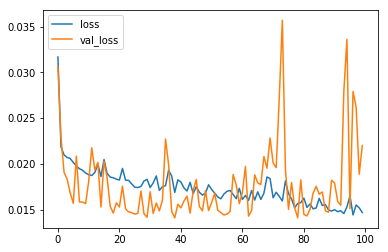

In [10]:
gen = Model(inputs, decoder(encoder(inputs)), name='Generator')
gan = Model(inputs, disc(gen(inputs)), name='GAN')
sgd = SGD(lr=1e-4, clipnorm=1, clipvalue=0.5)
disc.compile(loss='mean_squared_logarithmic_error', optimizer=sgd,  metrics=['acc'])
gen.compile(loss='mean_squared_logarithmic_error', optimizer=sgd,  metrics=['acc'])
gan.compile(loss='mean_squared_logarithmic_error', optimizer=sgd,  metrics=['acc'])
#intial training
gen = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
gen.summary()
sgd = SGD(lr=10, clipnorm=1, clipvalue=0.5)
gen.compile(loss='mean_squared_logarithmic_error', optimizer=sgd,  metrics=['acc'])
gen.fit(x_train,
                target_data_train,
                validation_data=(x_test, target_data_test),
                callbacks=[plot_losses],
                verbose=0,
                epochs=100,
                batch_size=32)

# GAN training Process (Custom) 

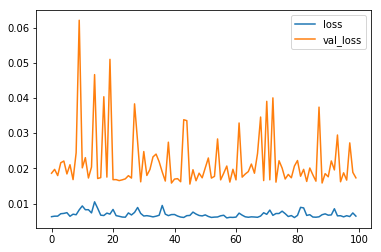

(200, 2)


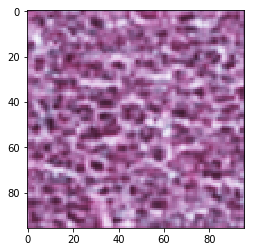

Done preprocess
Done Compile
DISCRIM TRAIN
Train on 200 samples, validate on 6 samples
Epoch 1/2
200/200 [==============================] - 11s 55ms/step - loss: 0.2207 - acc: 0.4700 - val_loss: 0.1605 - val_acc: 0.5000
Epoch 2/2
200/200 [==============================] - 9s 43ms/step - loss: 0.2121 - acc: 0.4950 - val_loss: 0.2220 - val_acc: 0.5000
GAN TRAIN
(100, 2)
Train on 100 samples, validate on 3 samples
Epoch 1/2
100/100 [==============================] - 11s 106ms/step - loss: 0.0083 - acc: 0.9800 - val_loss: 6.4916e-05 - val_acc: 1.0000
Epoch 2/2
100/100 [==============================] - 7s 65ms/step - loss: 4.4941e-05 - acc: 1.0000 - val_loss: 3.2156e-05 - val_acc: 1.0000
5


In [12]:
train = []
epoch=5
num_sample=100
num_test_sample = 3
num_classes = 2
for i in range (epoch):
    #Retrain the generator network again 
    print('Retrain Original Net')
    gen.compile(loss='mean_squared_logarithmic_error', optimizer=sgd,  metrics=['acc'])
    gen.fit(x_train,
                target_data_train,
                validation_data=(x_test, target_data_test),
                callbacks=[plot_losses],
                verbose=0,
                epochs=100,
                batch_size=32)
    #Train the Discriminator on fake and real images
    real_labels = np.ones((num_sample*2,),dtype='int64')
    real_labels[0:100]=1
    real_labels[100:200]=0
    real_labels = np_utils.to_categorical(real_labels, num_classes)
    print(real_labels.shape)
    real_test_label = np.ones((num_test_sample*2,),dtype='int64')
    real_test_label[0:3]=1
    real_test_label[3:6]=0
    real_test_label = np_utils.to_categorical(real_test_label, num_classes)
    
    fake = gen.predict(x_train)
    look = fake[12, : , :, :]
    look =(look*255).astype(np.uint8)
    plt.imshow(look,  interpolation='none', cmap='gray')
    plt.show()
    Image.fromarray(look).save('training'+str(i)+'.png')
    
    fake_test = gen.predict(x_test)
    train = np.concatenate([target_data_train, fake])
    train = shuffle(train, random_state=2)
    test = np.concatenate([target_data_test, fake_test])
    test = shuffle(test, random_state=2)
    real_labels = shuffle(real_labels, random_state=2)
    real_test_label = shuffle(real_test_label, random_state=2)
    test = np.concatenate([target_data_test, fake_test])
    print('Done preprocess')
    disc.compile(loss='mean_squared_logarithmic_error', optimizer=sgd,  metrics=['acc'])
    print('Done Compile')
    print('DISCRIM TRAIN')
    disc.fit(train,real_labels,
                validation_data=(test, real_test_label),
                epochs=2,
                batch_size=1)
    #Train the entire GAN network based on random inputs
    print('GAN TRAIN')
    real_labels = np.zeros((num_sample,),dtype='int64')
    real_labels = np_utils.to_categorical(real_labels, num_classes)
    print(real_labels.shape)
    real_test_label = np.zeros((num_test_sample,),dtype='int64')
    real_test_label = np_utils.to_categorical(real_test_label, num_classes)
    gan.compile(loss='mean_squared_logarithmic_error', optimizer=sgd,  metrics=['acc'])
    gan.fit(x_train,real_labels,
                validation_data=(x_test, real_test_label),
                epochs=2,
                batch_size=1) 

    i+=1
    print(i)

# Test The Network

(100, 96, 96, 3)


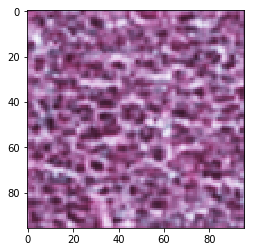

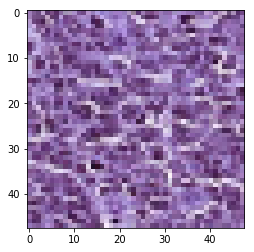

In [16]:
x_decoded = gen.predict(x_train)
from PIL import Image
print(x_decoded.shape)
test = x_decoded[12, : , :, :]
test =(test*255).astype(np.uint8)
plt.imshow(test,  interpolation='none', cmap='gray')
plt.show()
Image.fromarray(test).save('decode1.png')
test1 = x_train[12, :, :, :]
test1 =(test1*255).astype(np.uint8)
plt.imshow(test1,  interpolation='none', cmap='gray')
plt.show()
Image.fromarray(test1).save('encode1.png')

#  Save And Load Model

In [15]:
fname = 'SRGAN.h5'
gen.save(fname,overwrite=True)
from keras.models import load_model
gen=load_model(fname)

D:\Anaconda\envs\Keras\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
